In [1]:
!pip install segmentation-models

In [2]:
import random
import cv2
import numpy as np
# import imutils
import os

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB7, EfficientNetB6, EfficientNetB4, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
import segmentation_models as sm

Segmentation Models: using `keras` framework.


/usr/local/lib/python3.10/dist-packages/efficientnet/__init__.py

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(tf.__version__)


2.17.1


# Praproses

In [5]:
# Constants

VAL_SIZE = 0.3
HEIGHT = 256
WIDTH = 256
# HEIGHT = 240
# WIDTH = 320
BATCH_SIZE = 16
EPOCHS = 15
INIT_LR = 1e-4
BACKBONE = "EfficientNetB4"
DECODER_FILTERS  = [256, 128, 64, 32, 16]
DEPTH_LOSS = [1.0, 1.0, 0.3]

TRAIN_PATH = "./data/nyu2_train.csv"
TEST_PATH = "./data/nyu2_test.csv"

BASE_DIR = '/content/drive/My Drive/CV'
HISTORY_SAVE_PATH = BASE_DIR + '/training results/tf_' + BACKBONE + '_.csv'
MODEL_SAVE_PATH = BASE_DIR + '/training results/tf_' + BACKBONE + '_1_best.keras'

In [6]:
os.makedirs(BASE_DIR + '/training results', exist_ok=True)

In [7]:
# download nyu depth v2 dataset from gitlab
!git clone https://gitlab.com/siddinc/new_depth.git ./data

fatal: destination path './data' already exists and is not an empty directory.


In [8]:
# loading the dataset as img and depth map filepaths

import csv

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, VAL_SIZE)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [9]:
# preprocessing the dataset

def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False, resize=True):
  image = cv2.imread(img_path)
  if image is None:
    print(f"Error: Could not load image at {img_path}")
    # Handle the error appropriately, e.g., return a default image or skip this sample
    return np.zeros((HEIGHT, WIDTH, 3), dtype=np.float32)
  if resize:
    image = cv2.resize(image, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
  image = image.astype("float")
  image = normalize_img(image)

  if horizontal_flip:
    image = cv2.flip(image, 1)
  return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
  depth_map = cv2.imread(depth_map_path)
  depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
  depth_map = cv2.resize(depth_map, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
  depth_map = depth_map.astype("float")
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)

  depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
  return depth_map

In [10]:
img_dm_pairs = read_csv('./data/nyu2_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

654


In [11]:
# custom loss
def depth_loss(y_true, y_pred):
  w1, w2, w3 = DEPTH_LOSS[0], DEPTH_LOSS[1], DEPTH_LOSS[2]

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom soft accuracy
def depth_acc(y_true, y_pred):
  # Ensure y_true and y_pred have the same data type
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [12]:
img_dm_pairs = read_csv('./data/nyu2_train.csv')
labels2 = {i: j for i,j in img_dm_pairs}
train_paths2 = [i for i,j in img_dm_pairs]
print(len(train_paths2))
partition2 = {'train': train_paths2}

32054


In [13]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rmzhang0526/nyu-depth-v2-labeled")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rmzhang0526/nyu-depth-v2-labeled/versions/1


In [15]:
# egen data generate
import h5py
import numpy as np

# Load the .mat file (adjust the file path as needed)
with h5py.File(path + '/nyu_depth_v2_labeled.mat', 'r') as file:
    # Access the data
    rgb_images = np.array(file['images'])  # Shape: (N, 3, 480, 640)
    depth_maps = np.array(file['depths'])  # Shape: (N, 480, 640)

# Transpose rgb_images to shape (N, 480, 640, 3) for better compatibility
rgb_images = rgb_images.transpose(0, 3, 2, 1)
depth_maps = depth_maps.transpose(0, 2, 1)

# Eigen test indices (replace with actual indices)
#984
# eigen_test_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984])  # Replace with the actual indices you want to use
# 654
eigen_test_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653])
# 100
# eigen_test_indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

eigen_test_rgb = rgb_images[eigen_test_indices]
eigen_test_depth = depth_maps[eigen_test_indices]

# Define crop values (Eigen et al. crop values)
# crop = [20, 460, 24, 616]  # [y_start, y_end, x_start, x_end]
crop = [0, 255, 0, 255]
# Crop the depth maps based on Eigen crop values
eigen_test_depth_cropped = eigen_test_depth[:, crop[0]:crop[1]+1, crop[2]:crop[3]+1]

# Save the generated arrays to .npy files
np.save('eigen_test_rgb.npy', eigen_test_rgb)
np.save('eigen_test_depth.npy', eigen_test_depth_cropped)
np.save('eigen_test_crop.npy', crop)

print("Eigen RGB, depth, and crop files generated and saved.")

Eigen RGB, depth, and crop files generated and saved.


In [16]:
from tensorflow.keras.layers import AveragePooling2D
from sklearn.metrics import r2_score

r2_scores = []

# Load test data
def load_test_data():
    print('Loading test data...', end='')

    rgb = np.load('eigen_test_rgb.npy')
    depth = np.load('eigen_test_depth.npy')
    crop = np.load('eigen_test_crop.npy')
    print('Test data loaded.\n')

    return rgb, depth, crop

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=6):
    # Support multiple RGBs, one RGB image, even grayscale

    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    images = tf.image.resize(images, [HEIGHT, WIDTH])
    predictions = model.predict(images, batch_size=batch_size)

    return predictions

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )
    return np.stack(scaled)
def safe_log10(x, epsilon=1e-8):
    """Compute log10 safely by adding a small epsilon to avoid log10(0)."""
    return np.log10(np.maximum(x, epsilon))
def evaluate(model, rgb, depth, crop, batch_size=6):
    def compute_errors(gt, pred):
        """Computation of error metrics between predicted and ground truth depths"""
        epsilon = 1e-6
        pred = np.where(pred > 0, pred, epsilon)
        gt = np.where(gt > 0, gt, epsilon)

        # Ensure shapes match
        if pred.shape != gt.shape:
            pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

        # Compute error metrics
        thresh = np.maximum((gt / pred), (pred / gt))
        a1 = (thresh < 1.25).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()
        abs_rel = np.mean(np.abs(gt - pred) / gt)
        rmse = np.sqrt(np.mean((gt - pred) ** 2))
        log_10 = np.mean(np.abs(np.log10(gt) - np.log10(pred)))
        return a1, a2, a3, abs_rel, rmse, log_10

    depth_scores = np.zeros((6, len(rgb)))  # six metrics
    bs = batch_size

    for i in range(len(rgb) // bs):  # Batch iteration
        x = rgb[i * bs:(i + 1) * bs, :, :, :]
        true_y = depth[i * bs:(i + 1) * bs, :, :]
        pred_y = scale_up(2, predict(model, x / 255, minDepth=10, maxDepth=1000, batch_size=bs)[:, :, :, 0]) * 10.0

        # Optional: Flip prediction for augmentation
        pred_y_flip = scale_up(2, predict(model, x[..., ::-1, :] / 255, minDepth=10, maxDepth=1000, batch_size=bs)[:, :, :, 0]) * 10.0

        pred_y = pred_y[:, crop[0]:crop[1] + 1, crop[2]:crop[3] + 1]

        for j in range(len(true_y)):
            errors = compute_errors(true_y[j], (0.75 * pred_y[j]))
            for k in range(len(errors)):
                depth_scores[k][(i * bs) + j] = errors[k]

    e = depth_scores.mean(axis=1)

    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
    print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

In [17]:
rgb, depth, crop = load_test_data()

Loading test data...Test data loaded.



In [18]:
import pandas as pd

# Load Dataset from CSV
def load_data_from_csv(csv_file, base_dir):
  images = []
  depths = []

  # Read the CSV file
  df = pd.read_csv(csv_file, header=None)
  df = df[:100]
  img_paths = df[0].values
  depth_paths = df[1].values

  for img_path, depth_path in zip(img_paths, depth_paths):
    # Load the image
    img = cv2.imread(os.path.join(base_dir, img_path))
    depth = cv2.imread(os.path.join(base_dir, depth_path), cv2.IMREAD_GRAYSCALE)

    if img is None or depth is None:
      print(f"Error loading {img_path} or {depth_path}")
      continue

    # Resize to match the model's input dimensions
    img = cv2.resize(img, (WIDTH, HEIGHT))
    depth = cv2.resize(depth, (WIDTH, HEIGHT))

    # Normalize images and depth maps
    images.append(img / 255.0)
    depths.append(depth / 255.0)

  return np.array(images), np.array(depths).reshape(-1, HEIGHT, WIDTH, 1)

In [19]:
from matplotlib import pyplot as plt
import random

def visualize_inference(model, images, depths, index=None):
  """
  Visualizes a random prediction from the test set.
  """
  # Choose a random index if not provided
  if index is None:
    index = random.randint(0, len(images) - 1)

  # Get the input image and corresponding ground truth depth
  input_image = images[index]
  true_depth = depths[index].squeeze()  # Remove single channel dimension for visualization

  # Predict depth using the model
  predicted_depth = model.predict(input_image[np.newaxis, ...])[0].squeeze()

  # Plot input image, ground truth, and predicted depth
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(input_image)
  plt.title("Input Image")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(true_depth, cmap='viridis')
  plt.title("Ground Truth Depth")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(predicted_depth, cmap='viridis')
  plt.title("Predicted Depth")
  plt.axis("off")

  plt.show()
# Prepare the test data
asdfimages_test, asdfdepths_test = load_data_from_csv(TEST_PATH, './')


In [20]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flop_model(model):
    # Convert the Keras model to a ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        tf.TensorSpec(model.input_shape, tf.float32)
    )

    # Convert the Keras model to a ConcreteFunction
    model_func = tf.function(lambda x: model(x))
    concrete_func = model_func.get_concrete_function(
        tf.TensorSpec(model.input_shape, tf.float32)
    )

    # Convert the ConcreteFunction to a frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph

    # Analyze FLOPs in the frozen graph
    def get_flops(graph):
        flops = {}
        for node in graph.as_graph_def().node:
            op_type = node.op
            if op_type not in flops:
                flops[op_type] = 0
            flops[op_type] += 1  # Increment count for this operation type
        return flops

    # Get FLOP statistics
    counts = 0
    flop_stats = get_flops(frozen_graph)
    for op_type, count in flop_stats.items():
        print(f"Operation Type: {op_type}, Count: {count}")
        counts += count
    print("all operation:", counts)

### Freeze model

In [32]:
# Constants
BASE_DIR = '/content/drive/My Drive/CV'

In [33]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(BASE_DIR + '/freeze_unet_relu.keras', custom_objects={'depth_loss': depth_loss, 'depth_acc': depth_acc})

In [34]:
get_flop_model(model)

Operation Type: Placeholder, Count: 1
Operation Type: Const, Count: 1653
Operation Type: Identity, Count: 661
Operation Type: Conv2D, Count: 139
Operation Type: Reshape, Count: 541
Operation Type: AddV2, Count: 302
Operation Type: Rsqrt, Count: 106
Operation Type: Mul, Count: 456
Operation Type: Sub, Count: 106
Operation Type: Sigmoid, Count: 128
Operation Type: DepthwiseConv2dNative, Count: 32
Operation Type: Mean, Count: 32
Operation Type: Shape, Count: 42
Operation Type: StridedSlice, Count: 62
Operation Type: Pack, Count: 52
Operation Type: ExpandDims, Count: 10
Operation Type: Cast, Count: 10
Operation Type: Tile, Count: 10
Operation Type: ConcatV2, Count: 14
Operation Type: Relu, Count: 11
Operation Type: NoOp, Count: 1
all operation: 4369


In [35]:
print(model.evaluate(x_test, y_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - depth_acc: 0.7850 - loss: 0.2223
[0.21465158462524414, 0.7956322431564331]


/usr/local/lib/python3.10/dist-packages/efficientnet/__init__.py

In [36]:
evaluate(model, rgb, depth, crop)

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


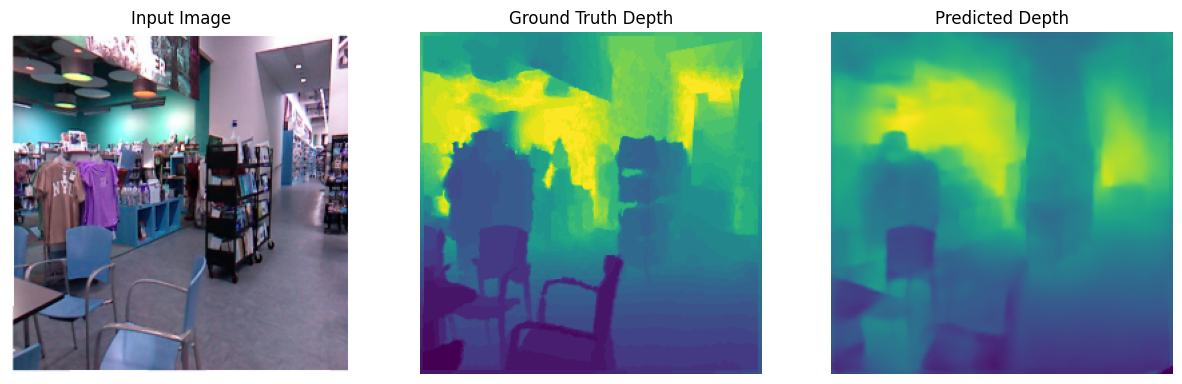

In [37]:

visualize_inference(model, asdfimages_test, asdfdepths_test)

In [38]:
tf.keras.backend.clear_session()

### UnFreeze model

In [39]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(BASE_DIR + '/unfreeze_unet.keras', custom_objects={'depth_loss': depth_loss, 'depth_acc': depth_acc})

In [40]:
get_flop_model(model)

Operation Type: Placeholder, Count: 1
Operation Type: Const, Count: 1460
Operation Type: Identity, Count: 665
Operation Type: Conv2D, Count: 138
Operation Type: Reshape, Count: 490
Operation Type: AddV2, Count: 309
Operation Type: Rsqrt, Count: 105
Operation Type: Mul, Count: 443
Operation Type: Sub, Count: 105
Operation Type: Sigmoid, Count: 128
Operation Type: DepthwiseConv2dNative, Count: 32
Operation Type: Mean, Count: 32
Operation Type: Shape, Count: 32
Operation Type: StridedSlice, Count: 32
Operation Type: Pack, Count: 32
Operation Type: ResizeBilinear, Count: 5
Operation Type: ConcatV2, Count: 4
Operation Type: Relu, Count: 10
Operation Type: NoOp, Count: 1
all operation: 4024


In [41]:
print(model.evaluate(x_test, y_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 841ms/step - depth_acc: 0.8474 - loss: 0.1851
[0.17977909743785858, 0.8553497791290283]


In [42]:
evaluate(model, rgb, depth, crop)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


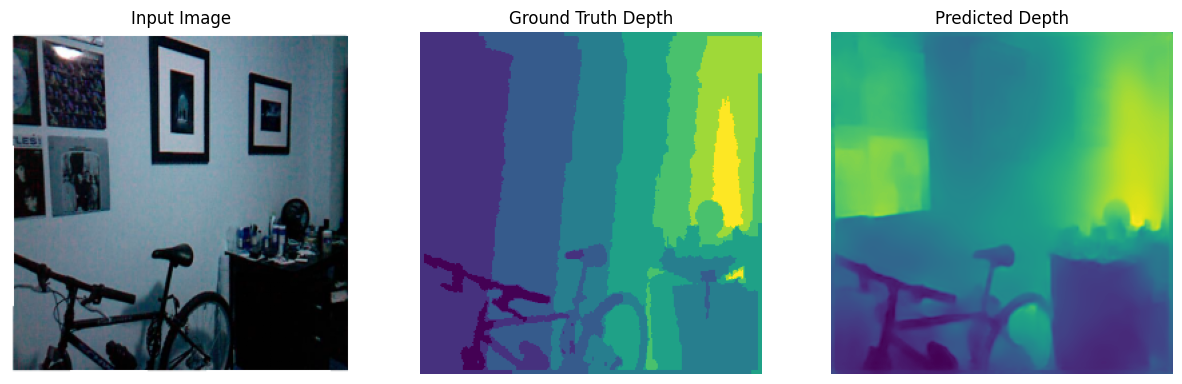

In [43]:

visualize_inference(model, asdfimages_test, asdfdepths_test)

In [44]:
tf.keras.backend.clear_session()

### unfreeze proejct bn model

In [21]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(BASE_DIR + '/unfreeze_project_bn.keras', custom_objects={'depth_loss': depth_loss, 'depth_acc': depth_acc})

In [22]:
get_flop_model(model)

Operation Type: Placeholder, Count: 1
Operation Type: Const, Count: 1460
Operation Type: Identity, Count: 665
Operation Type: Conv2D, Count: 138
Operation Type: Reshape, Count: 490
Operation Type: AddV2, Count: 309
Operation Type: Rsqrt, Count: 105
Operation Type: Mul, Count: 443
Operation Type: Sub, Count: 105
Operation Type: Sigmoid, Count: 128
Operation Type: DepthwiseConv2dNative, Count: 32
Operation Type: Mean, Count: 32
Operation Type: Shape, Count: 32
Operation Type: StridedSlice, Count: 32
Operation Type: Pack, Count: 32
Operation Type: ResizeBilinear, Count: 5
Operation Type: ConcatV2, Count: 4
Operation Type: Relu, Count: 10
Operation Type: NoOp, Count: 1
all operation: 4024


In [23]:
print(model.evaluate(x_test, y_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 996ms/step - depth_acc: 0.8498 - loss: 0.1877
[0.18202298879623413, 0.8593930006027222]


In [24]:
evaluate(model, rgb, depth, crop)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


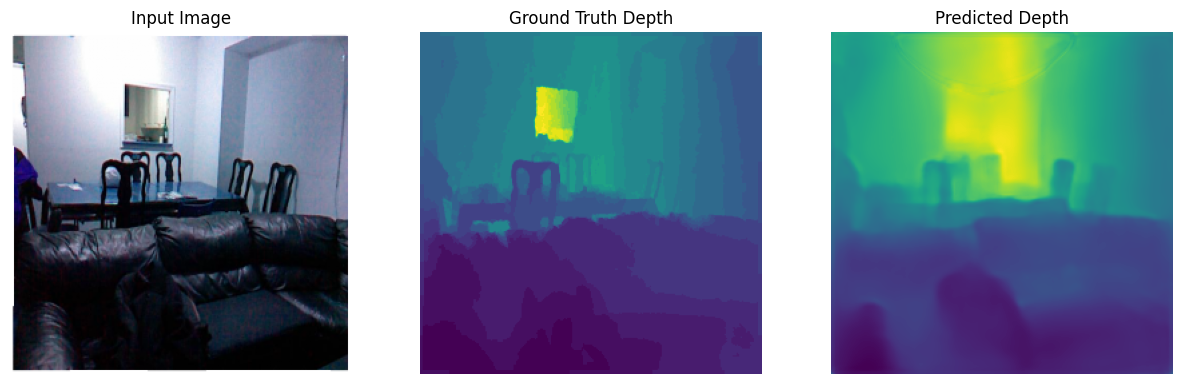

In [25]:

visualize_inference(model, asdfimages_test, asdfdepths_test)

In [26]:
tf.keras.backend.clear_session()